<a href="https://colab.research.google.com/github/plaban1981/Haystack_NLP/blob/main/Haystack_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is Haystack?


**Haystack** is an open-source framework for building search systems that work intelligently over large document collections.

* Recent advances in NLP have enabled the application of question answering, retrieval and summarization to real world settings and **Haystack is designed to be the bridge between research and industry**

* Latest NLP models: Utilize all transformer based models (BERT, RoBERTa, MiniLM, DPR ...) and smoothly switch when new ones get published
* Flexible databases: Load data into and query from a range of databases such as Elasticsearch, Milvus, FAISS, SQL and more
* Scalability: Production-ready deployments that scale to millions of documents
* End-to-End: All tooling you need to implement, evaluate, improve and run a search system
* Domain adaptation: Fine-tune models to your own domain & improve them continuously via user feedback

## Retriever-Reader

* The most common system built with Haystack is the Retriever-Reader Pipeline 

* it is designed to optimize for both speed and performance on the task of Open Domain Question Answering. 

* In practice, this is a great back bone for creating a search system that can handle detailed full sentence queries.

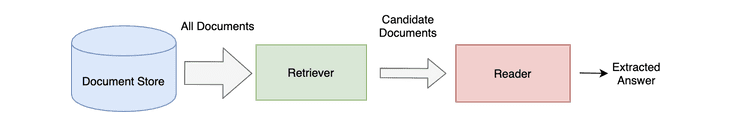

## Readers 

* Readers, also known as Open-Domain QA systems in Machine Learning speak, are powerful models that do close analysis of documents and perform the core task of question answering. 

* The Readers in Haystack are trained from the latest transformer based language models and can be significantly sped up using GPU acceleration. 

* However, it is not currently feasible to use the Reader directly on large collection of documents.

## Retriever

* The Retriever assists the Reader by acting as a lightweight filter that reduces the number of documents that the Reader has to process. 

It does this by:

  * Scanning through all documents in the database
  * Quickly identifying the relevant and dismissing the irrelevant
  * Passing on only a small candidate set of documents to the Reader

Current methods fall into one of the two categories:

* sparse

      - keyword based
      - fast indexing and querying
      - e.g. BM25
      
* dense

      - neural network based
      - computationally heavy indexing but fast querying
      - e.g. Dense Passage Retrieval
    


## Installation
To start, install the latest release of Haystack with pip:

In [2]:
%%bash

nvidia-smi

Tue Nov 15 11:28:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install farm-haystack[colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%%bash

pip install --upgrade pip
pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-x6f_1h_8/farm-haystack_67e9ab6e25344e419888d948f351e15b
  Resolved https://github.com/deepset-ai/haystack.git to commit 6ce2d296f4cd34059905817f0a2717801ba27c61
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with sta

  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-x6f_1h_8/farm-haystack_67e9ab6e25344e419888d948f351e15b
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.48.2 requires grpcio>=1.48.2, but you have grpcio 1.47.0 which is incompatible.


## Logging

In [3]:
import logging
logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

## Document Store

Haystack finds answers to queries within the documents stored in a `DocumentStore`. 

The current implementations of `DocumentStore` include 
* `ElasticsearchDocumentStore`, 
* `FAISSDocumentStore`,  
* `SQLDocumentStore`, and 
* `InMemoryDocumentStore`.

**Here:** We recommended Elasticsearch as it comes preloaded with features like [full-text queries](https://www.elastic.co/guide/en/elasticsearch/reference/current/full-text-queries.html), [BM25 retrieval](https://www.elastic.co/elasticon/conf/2016/sf/improved-text-scoring-with-bm25), and [vector storage for text embeddings](https://www.elastic.co/guide/en/elasticsearch/reference/7.6/dense-vector.html).

**Alternatives:** If you are unable to setup an Elasticsearch instance, then follow the [Tutorial 3](https://github.com/deepset-ai/haystack-tutorials/blob/main/tutorials/03_Basic_QA_Pipeline_without_Elasticsearch.ipynb) for using SQL/InMemory document stores.

**Hint**: This tutorial creates a new document store instance with Wikipedia articles on Game of Thrones. However, you can configure Haystack to work with your existing document stores.

### Start an Elasticsearch server locally
You can start Elasticsearch on your local machine instance using Docker. If Docker is not readily available in your environment (e.g. in Colab notebooks), then you can manually download and execute Elasticsearch from source.

In [6]:
# Recommended: Start Elasticsearch using Docker via the Haystack utility function
from haystack.utils import launch_es

launch_es()

## Start an Elasticsearch server in Colab
If Docker is not readily available in your environment (e.g. in Colab notebooks), then you can manually download and execute Elasticsearch from source.

In [7]:
%%bash

wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
chown -R daemon:daemon elasticsearch-7.9.2

In [8]:
%%bash --bg

sudo -u daemon -- elasticsearch-7.9.2/bin/elasticsearch

### Create the Document Store

The `ElasticsearchDocumentStore` class will try to open a connection in the constructor, here we wait 30 seconds only to be sure Elasticsearch is ready before continuing:

In [9]:
import time
time.sleep(30)

## Finally, we create the Document Store instance:

In [10]:
import os
from haystack.document_stores import ElasticsearchDocumentStore

# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")
document_store = ElasticsearchDocumentStore(host=host, username="", password="", index="document")


## Preprocessing of documents
Haystack provides a customizable pipeline for:

* converting files into texts
* cleaning texts
* splitting texts
* writing them to a Document Store

In [11]:
from haystack.utils import clean_wiki_text, convert_files_to_docs, fetch_archive_from_http


# Let's first fetch some documents that we want to query
# Here: 517 Wikipedia articles for Game of Thrones
doc_dir = "data/tutorial1"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt1.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Convert files to dicts
# You can optionally supply a cleaning function that is applied to each doc (e.g. to remove footers)
# It must take a str as input, and return a str.
docs = convert_files_to_docs(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

# We now have a list of dictionaries that we can write to our document store.
# If your texts come from a different source (e.g. a DB), you can of course skip convert_files_to_dicts() and create the dictionaries yourself.
# The default format here is:
# {
#    'content': "<DOCUMENT_TEXT_HERE>",
#    'meta': {'name': "<DOCUMENT_NAME_HERE>", ...}
# }
# (Optionally: you can also add more key-value-pairs here, that will be indexed as fields in Elasticsearch and
# can be accessed later for filtering or shown in the responses of the Pipeline)

# Let's have a look at the first 3 entries:
print(docs[:3])

# Now, let's write the dicts containing documents to our DB.
document_store.write_documents(docs)

[<Document: {'content': '"\'\'\'The Pointy End\'\'\'" is the eighth episode of the first season of the HBO medieval fantasy television series \'\'Game of Thrones\'\'. First aired on June 5, 2011, the episode was directed by Daniel Minahan and written by George R. R. Martin, the author of the \'\'A Song of Ice and Fire\'\' novels on which the show is based.\nThe plot covers the aftermath of Eddard Stark\'s capture. While the Lannisters seek to capture his daughters, his son and heir, Robb, raises an army in the North. Meanwhile, Daenerys witnesses a Dothraki raid on a peaceful village, and Jon Snow faces a new threat at the Wall. The episode\'s title refers to the sword fighting lesson that Jon gave to Arya before their farewell: "Stick them with the pointy end."\nThe episode was well received by critics, who praised Martin\'s adaptation of his own work as well as the actors\' performances. It was dedicated to Ralph Vicinanza, an executive producer who died of natural causes. In the Uni

* In Haystack, DocumentStores expect Documents in a dictionary format.
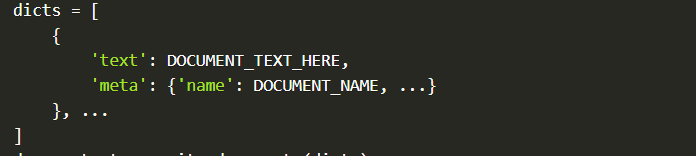

## Initalize Retriever, Reader, & Pipeline

## Retriever : Interacts with the DocumentStore

### Retriever

* Retrievers help narrowing down the scope for the Reader to smaller units of text where a given question could be answered. 
* They use some simple but fast algorithm.

Here: We use Elasticsearch’s default BM25 algorithm

**Alternatives:**

- Customize the `BM25Retriever`with custom queries (e.g. boosting) and filters
- Use `TfidfRetriever` in combination with a SQL or InMemory Document store for simple prototyping and debugging
- Use `EmbeddingRetriever` to find candidate documents based on the similarity of embeddings (e.g. created via Sentence-BERT)
- Use `DensePassageRetriever` to use different embedding models for passage and query (see Tutorial 6)

In [12]:
from haystack.nodes import BM25Retriever
retriever = BM25Retriever(document_store=document_store)

In [13]:
# Alternative: An in-memory TfidfRetriever based on Pandas dataframes for building quick-prototypes with SQLite document store.

# from haystack.nodes import TfidfRetriever
# retriever = TfidfRetriever(document_store=document_store)

### Reader

A Reader scans the texts returned by retrievers in detail and extracts the k best answers. They are based
on powerful, but slower deep learning models.

Haystack currently supports Readers based on the frameworks **FARM** and **Transformers**.
With both you can either load a local model or one from Hugging Face's model hub (https://huggingface.co/models).

**Here:** a medium sized RoBERTa QA model using a Reader based on FARM (https://huggingface.co/deepset/roberta-base-squad2)

**Alternatives (Reader):** TransformersReader (leveraging the `pipeline` of the Transformers package)

**Alternatives (Models):** e.g. "distilbert-base-uncased-distilled-squad" (fast) or "deepset/bert-large-uncased-whole-word-masking-squad2" (good accuracy)

**Hint:** You can adjust the model to return "no answer possible" with the no_ans_boost. Higher values mean the model prefers "no answer possible"

#### FARMReader

In [14]:
from haystack.nodes import FARMReader

# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

#### TransformersReader

Alternative:

In [15]:
from haystack.nodes import TransformersReader
# reader = TransformersReader(model_name_or_path="distilbert-base-uncased-distilled-squad", tokenizer="distilbert-base-uncased", use_gpu=-1)

### Pipeline

With a Haystack `Pipeline` you can stick together your building blocks to a search **pipeline**.
Under the hood, `Pipelines` are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases.
To speed things up, Haystack also comes with a few predefined Pipelines. One of them is the `ExtractiveQAPipeline` that combines a retriever and a reader to answer our questions.
You can learn more about `Pipelines` in the [docs](https://haystack.deepset.ai/docs/latest/pipelines).

In [16]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

##AskQuestion

In [17]:
# You can configure how many candidates the Reader and Retriever shall return
# The higher top_k_retriever, the better (but also the slower) your answers.
prediction = pipe.run(
    query="Who is the father of Arya Stark?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)


Inferencing Samples: 100%|██████████| 1/1 [00:03<00:00,  3.01s/ Batches]


In [18]:
from pprint import pprint

pprint(prediction)


{'answers': [<Answer {'answer': 'Eddard', 'type': 'extractive', 'score': 0.9919580221176147, 'context': "s Nymeria after a legendary warrior queen. She travels with her father, Eddard, to King's Landing when he is made Hand of the King. Before she leaves,", 'offsets_in_document': [{'start': 147, 'end': 153}], 'offsets_in_context': [{'start': 72, 'end': 78}], 'document_id': 'ba2a8e87ddd95e380bec55983ee7d55f', 'meta': {'name': '43_Arya_Stark.txt'}}>,
             <Answer {'answer': 'Ned', 'type': 'extractive', 'score': 0.97672438621521, 'context': "\n====Season 1====\nArya accompanies her father Ned and her sister Sansa to King's Landing. Before their departure, Arya's half-brother Jon Snow gifts A", 'offsets_in_document': [{'start': 46, 'end': 49}], 'offsets_in_context': [{'start': 46, 'end': 49}], 'document_id': '180c2a6b36369712b361a80842e79356', 'meta': {'name': '43_Arya_Stark.txt'}}>,
             <Answer {'answer': 'Lord Eddard Stark', 'type': 'extractive', 'score': 0.8930398821830

In [19]:
from haystack.utils import print_answers

# Change `minimum` to `medium` or `all` to raise the level of detail
print_answers(prediction, details="minimum")


Query: Who is the father of Arya Stark?
Answers:
[   {   'answer': 'Eddard',
        'context': 's Nymeria after a legendary warrior queen. She travels '
                   "with her father, Eddard, to King's Landing when he is made "
                   'Hand of the King. Before she leaves,'},
    {   'answer': 'Ned',
        'context': '\n'
                   '====Season 1====\n'
                   'Arya accompanies her father Ned and her sister Sansa to '
                   "King's Landing. Before their departure, Arya's "
                   'half-brother Jon Snow gifts A'},
    {   'answer': 'Lord Eddard Stark',
        'context': 'ark daughters.\n'
                   'During the Tourney of the Hand to honour her father Lord '
                   'Eddard Stark, Sansa Stark is enchanted by the knights '
                   'performing in the event.'},
    {   'answer': 'Joffrey',
        'context': 'laying with one of his wooden toys.\n'
                   "After Eddard discovers the 